# Importing required libs

In [1]:
import tensorflow as tf
import time
# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# List available physical devices
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:")
for device in physical_devices:
    print(device)
    
# Check if TensorFlow is using the GPU
if tf.test.is_built_with_cuda():
    print("TensorFlow is built with CUDA")
    if len(physical_devices) > 0:
        print("TensorFlow is using the GPU")
    else:
        print("TensorFlow is not using the GPU, but it is available")
else:
    print("TensorFlow is not built with CUDA")


TensorFlow version: 2.6.0
Available GPUs:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow is built with CUDA
TensorFlow is using the GPU


In [2]:
%run generator.ipynb
%run model.ipynb

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,Callback,LearningRateScheduler , TensorBoard
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras import backend as K
import os
import datetime
import numpy as np
import shutil
# from skimage import morphology, feature, segmentation, measure, io, color
# from skimage.filters import sobel
import matplotlib.pyplot as plt
import cv2
import pdb
import imageio
from scipy import misc
import scipy.ndimage as ndimage
import warnings
warnings.filterwarnings('ignore')
# from google.colab.patches import cv2_imshow  # Only required in Google Colab
import numpy as np
import tensorflow as tf
import datetime
import time
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

# Visualization methods

In [12]:
def to_three_channels(img):
  return np.squeeze(np.stack((img,img,img), 2))

def show_sample(img, anno, label):
  squeezed =  np.squeeze(anno)

  figure, axis = plt.subplots(1,3)
  axis[0].imshow(img)
  axis[1].imshow(squeezed)
  squeezed =  np.squeeze(label)
  axis[2].imshow(squeezed)




def show_batch(img, label):
  show_sample(img[0,:,:,:],label[0,:,:,:])

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

def save_sample(img, label , gt,  folder_name , sample_file_name, lable_type , counts):
    folder_name = folder_name + str(sample_file_name).split("dic.png")[0] + "/"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(folder_name)
        output_path = os.path.join(folder_name, 'counts.txt')
        with open(output_path, 'w') as file:
            file.write(str(counts) + '\n')
    
    
    squeezed_label =  np.squeeze(label)
    squeezed_gt =  np.squeeze(gt)
    

    # Ensure images are in the correct range
    if img.dtype == np.float64 or img.dtype == np.float32:
        img = np.interp(img, (img.min(), img.max()), (0, 1))
    
    if squeezed_label.dtype == np.float64 or squeezed_label.dtype == np.float32:
        squeezed_label = np.interp(squeezed_label, (squeezed_label.min(), squeezed_label.max()), (0, 1))
    if squeezed_gt.dtype == np.float64 or squeezed_gt.dtype == np.float32:
        squeezed_gt = np.interp(squeezed_gt, (squeezed_gt.min(), squeezed_gt.max()), (0, 1))
    

    # Save the first image
    fig, ax = plt.subplots()
    ax.imshow(img)
    # ax.set_title('Image')
    plt.axis('off')  # Turn off the axis
    output_path = os.path.join(folder_name, 'image_1.jpg')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)  # Save without white spaces
    plt.close(fig)  # Close the figure to free up memory
    
    
    # Save the third image
    fig, ax = plt.subplots()
    ax.imshow(squeezed_label)
    # ax.set_title('Squeezed Label')
    plt.axis('off')  # Turn off the axis
    output_path = os.path.join(folder_name, 'image_pr_'+lable_type+'.jpg')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)  # Save without white spaces
    plt.close(fig)  # Close the figure to free up memory

     # Save the third image
    fig, ax = plt.subplots()
    ax.imshow(squeezed_gt)
    # ax.set_title('Squeezed gt')
    plt.axis('off')  # Turn off the axis
    output_path = os.path.join(folder_name, 'image_gt_'+lable_type+'.jpg')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)  # Save without white spaces
    plt.close(fig)  # Close the figure to free up memory
    # plt.show()


def show_save_all_sample(img , c_label , c_gt , r_label , r_gt , folder_name , sample_file_name , counts ):
    
    squeezed_r_label = np.squeeze(r_label)
    squeezed_c_label = np.squeeze(c_label)
    # Ensure images are in the correct range
    if img.dtype == np.float64 or img.dtype == np.float32:
        img = np.interp(img, (img.min(), img.max()), (0, 1))
   
    if squeezed_c_label.dtype == np.float64 or squeezed_c_label.dtype == np.float32:
        squeezed_c_label = np.interp(squeezed_c_label, (squeezed_c_label.min(), squeezed_c_label.max()), (0, 1))

    
    if squeezed_r_label.dtype == np.float64 or squeezed_c_label.dtype == np.float32:
        squeezed_r_label = np.interp(squeezed_r_label, (squeezed_r_label.min(), squeezed_r_label.max()), (0, 1))
        
   
    figure, axis = plt.subplots(1, 5, figsize=(15, 5))
    axis[0].imshow(img)
    axis[0].set_title('Image')
    axis[0].axis('off')
    
  
    axis[1].imshow(c_gt)
    axis[1].set_title('Centroids Ground Truth')
    axis[1].axis('off')
    
    axis[2].imshow(squeezed_c_label)
    axis[2].set_title('Centroids Prediction')
    axis[2].axis('off')

    
                 
    axis[3].imshow(r_gt)
    axis[3].set_title('Regions Ground Truth')
    axis[3].axis('off')
    
    axis[4].imshow(squeezed_r_label)
    axis[4].set_title('Regions Prediction')
    axis[4].axis('off')

    plt.show()
    save_sample(img, c_label ,c_gt, folder_name , sample_file_name, "centroids" , counts)
    save_sample(img, r_label ,r_gt, folder_name , sample_file_name, "regions" , counts )
    



# preparing the dataset

In [5]:
# Setting dimensions
image_height = 256
image_width = 256

## Generating DIC like images

In [10]:
base_address= 'C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper'

In [24]:
folder_path = base_address +'/real_dataset/data_80_cells/'
output_folder_path = base_address+'/real_dataset/data_80_dics/'

files = os.listdir(folder_path)

for file in files:
    # Create the full file path
    print(os.path.join(folder_path, file))
    if 'ipynb_checkpoints' not in os.path.join(folder_path, file) :

        file_path = os.path.join(folder_path, file)
        # Load the input image
        input_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
        # Apply gradient filter to find edges of the cells
        gradient_x = cv2.Sobel(input_image, cv2.CV_64F, 1, 0, ksize=3)
        gradient_y = cv2.Sobel(input_image, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)
    
        # Normalize gradient magnitude to [0, 255]
        gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)
    
        # Simulate shading
        shading_strength = 0.5 # Adjust this parameter to control shading strength
        shading = np.ones_like(input_image, dtype=np.float64) * 127
        shading += shading_strength * gradient_magnitude
    
        # Add shading to the input image
        output_image = cv2.add(input_image, shading.astype(np.uint8))
    
        new_file_name = file.replace('cell.png', '_dic.png')
    
        output_file_path = os.path.join(output_folder_path, new_file_name)
        print(output_file_path)
        cv2.imwrite(output_file_path, output_image)

C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper/real_dataset/data_80_cells/.ipynb_checkpoints
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper/real_dataset/data_80_cells/001cell.png
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper/real_dataset/data_80_dics/001_dic.png
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper/real_dataset/data_80_cells/002cell.png
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper/real_dataset/data_80_dics/002_dic.png
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper/real_dataset/data_80_cells/003cell.png
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper/real_dataset/data_80_dics/003_dic.png
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper/real_dataset/data_80_cells/004cell.png
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper/real_dataset/data_80_dics/004_dic.png
C:/User

## Generating regions images

In [30]:
centroids_path = base_address+ './real_dataset/data_80_dots/'
regions_path =base_address+'./real_dataset/data_80_regions/'

data = []
anno = []
img_labels=[]
def show_maped_centroids(centroids_path):
  imList = os.listdir(centroids_path)
  for i in range(len(imList)):
          # read the original image
          binary_image = cv2.imread( os.path.join(centroids_path, imList[i]) , cv2.IMREAD_GRAYSCALE)
          print(binary_image.shape)
          black_image = np.zeros((image_height, image_width, 1), dtype=np.uint8)

          white_pixel_locations = np.where(binary_image >0)

          for y, x in zip(*white_pixel_locations):
              cv2.circle(black_image, (x, y), 7 , 255, -1)  # Draw a red circle at each white pixel location
              cv2.circle(binary_image, (x, y), 7 , 255, -1)  # Draw a red circle at each white pixel location

          # Show the result image
          # cv2_imshow(black_image)
          # cv2_imshow(binary_image)
          cv2.imwrite( str(regions_path+ str( imList[i][:3] )+ 'regions.png')  , black_image )

          print(str(os.path.join(centroids_path, imList[i][:3])) , "\n\n\n"  )
show_maped_centroids(centroids_path)

(256, 256)
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper./real_dataset/data_80_dots/001 



(256, 256)
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper./real_dataset/data_80_dots/002 



(256, 256)
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper./real_dataset/data_80_dots/003 



(256, 256)
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper./real_dataset/data_80_dots/004 



(256, 256)
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper./real_dataset/data_80_dots/005 



(256, 256)
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper./real_dataset/data_80_dots/006 



(256, 256)
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper./real_dataset/data_80_dots/007 



(256, 256)
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper./real_dataset/data_80_dots/008 



(256, 256)
C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_

# U-Net Centroids

In [20]:
# !pip install scikit-learn --no-deps
# !pip install joblib --no-deps
# !pip install threadpoolctl --no-deps


  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [4]:


# Assuming the model building function is defined as `buildModel_Light_U_net`
# Example: model = buildModel_Light_U_net(input_dim=(256, 256, 3))

def step_decay(epoch):
    step = 16
    lrate = 1e0
    num = epoch // step
    if num % 3 == 0:
        lrate = 1e-3
    elif num % 3 == 1:
        lrate = 1e-4
    else:
        lrate = 1e-5
    print('Learning rate for epoch {} is {}.'.format(epoch+1, lrate))
    return float(lrate)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 5-Fold Cross Validation implementation
def train_with_kfold(data, anno, n_splits=5):
    # Step 1: Preprocessing data (Standardization)
    mean = np.mean(data)
    std = np.std(data)
    data_ = (data - mean) / std

    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []  # To store results for each fold
    durations=[]
    fold = 1

    for train_index, val_index in kf.split(data_):
        print(f"Training fold {fold}/{n_splits}")

        # Split data into training and validation sets based on the current fold
        train_data, val_data = data_[train_index], data_[val_index]
        train_anno, val_anno = anno[train_index], anno[val_index]

        # Build and compile the model
        model = build_unet_model(input_dim=(256, 256, 3))
        model_checkpoint = ModelCheckpoint(f'checkpoints/U_Net_centroids_fold{fold}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.hdf5', 
                                           monitor='loss', save_best_only=True)
        model.summary()
        
        # Learning rate scheduler
        change_lr = LearningRateScheduler(step_decay)

        # Data augmentation configuration
        datagen = ImageDataGenerator(
            featurewise_center=False,  
            samplewise_center=False,
            featurewise_std_normalization=False,  
            samplewise_std_normalization=False,
            zca_whitening=False,  
            rotation_range=30,  
            width_shift_range=0.3,  
            height_shift_range=0.3,  
            zoom_range=0.3,
            shear_range=0.,
            horizontal_flip=True,  
            vertical_flip=True, 
            fill_mode='constant',
            # dim_ordering='tf'
        )
        start_time = time.time()

        # Fit the model on the current fold's training data
        history = model.fit_generator(
            datagen.flow(train_data, train_anno, batch_size=4),
            steps_per_epoch=train_data.shape[0]//4 ,  # Calculate steps per epoch based on batch size
            epochs=50,
            callbacks=[model_checkpoint, change_lr]
        )
        end_time = time.time()
        duration = end_time - start_time  # duration in seconds

        # Print training duration
        print(f"Training duration: {duration:.2f} seconds")
        print(f"Training duration: {duration / 60:.2f} minutes")
        durations.append(duration)
        # Store fold result (you can also evaluate on validation data if needed)
        fold_results.append(history.history)
        fold += 1

    return fold_results , durations

# Centroids

In [5]:
base_address= 'C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper'
input_image_folder= base_address+ '/real_dataset/data_80_dics/'

label_center_folder= base_address+ '/real_dataset/data_80_dots/'

In [6]:

def load_images_from_folder(input_image_folder , label_image_folder , type_of_label , factor= 100):
    images = []
    labels = []
    dots_count=[]
    file_names=[]
    for filename in os.listdir(input_image_folder):
        img_path = os.path.join(input_image_folder, filename)
        label_path = os.path.join(label_image_folder, filename[:-8] + 'dots.png')

        # print("input", img_path)
        # print("lable", label_path)
        file_names.append(filename)
        img = cv2.imread(img_path)  # Read as grayscale
        label_image = cv2.imread( label_path )
        # plt.imshow(label_image)
        # plt.axis('off')  # Turn off axis numbers and ticks
        # plt.show()        
        label_image1= label_image
        if type_of_label== 'center':
          label_image= factor * (label_image[:,:,2] > 0)
        label_image = np.expand_dims(label_image, axis=-1)
        # print(label_image.shape)  # Output: (256, 256, 1)
        # print(np.unique(label_image))
        dots_count.append(str(np.sum(label_image1[:,:,2] > 0)))

        if img is not None and label_image is not None :
            # print(img.shape , np.unique(label_image) )
            images.append(img)
            labels.append(label_image)
    return np.array(images), np.array(labels) , np.array(dots_count) , np.array(file_names)

In [7]:
data, anno_centroids , counts , centroids_file_names = load_images_from_folder(input_image_folder , label_center_folder , "center")
print(f'Loaded {len(data)} cell images and  {len(anno_centroids)} regions label images.')

Loaded 80 cell images and  80 regions label images.


# train

In [6]:
from tensorflow.keras import backend as K
import gc

def clear_memory():
    K.clear_session()
    gc.collect()
clear_memory()

In [8]:
historys_center , durations = train_with_kfold(data, anno_centroids)

Training fold 1/5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
____________________________________________________________________________

## loss chart

In [9]:
def plot_loss(fold_results):
    """
    Plot the training loss curves for each fold.
    """
    plt.figure(figsize=(10, 6))

    # Iterate through each fold's history
    for fold_idx, history in enumerate(fold_results, 1):
        loss = history['loss']
        plt.plot(loss, label=f'Fold {fold_idx}')
    
    # Add title and labels
    plt.title('Training Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_average_training_time(durations):
    """
    Plot the average training time for each fold.
    """
    avg_time = np.mean(durations)
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(durations) + 1), durations, color='b', alpha=0.6)
    
    # Plot the average line
    plt.axhline(avg_time, color='r', linestyle='--', label=f'Avg Training Time: {avg_time/60:.2f} min')
    
    # Add title and labels
    plt.title('Training Time per Fold')
    plt.xlabel('Fold')
    plt.ylabel('Training Time (seconds)')
    plt.legend()
    plt.show()

def summarize_results(fold_results, durations):
    """
    Summarize the results by plotting loss curves and average training time.
    """
    # Plot the loss curves for all folds
    plot_loss(fold_results)
    
    # Plot the average training time for all folds
    plot_average_training_time(durations)


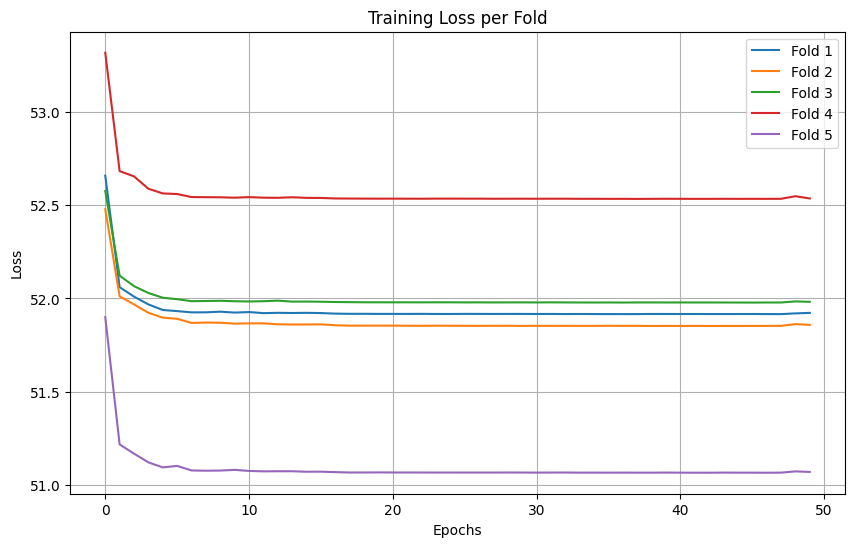

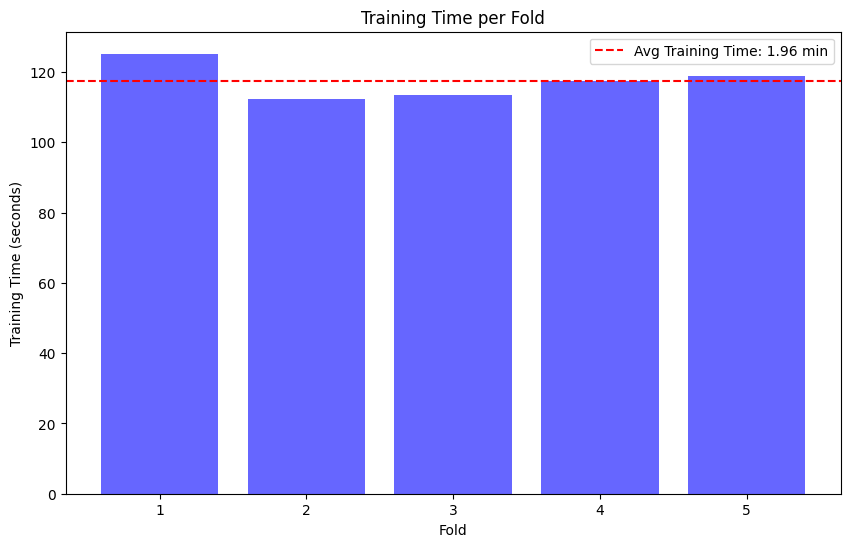

In [11]:
import matplotlib.pyplot as plt

summarize_results(historys_center, durations)


# U-Net Regions

In [12]:
def step_decay(epoch):
    step = 16
    lrate=1e0
    num =  epoch // step
    if num % 3 == 0:
        lrate = 1e-3
    elif num % 3 == 1:
        lrate = 1e-4
    else:
        lrate = 1e-5
        #lrate = initial_lrate * 1/(1 + decay * (epoch - num * step))
    print('Learning rate for epoch {} is {}.'.format(epoch+1, lrate))
    return float(lrate)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

tf.config.run_functions_eagerly(True)
np.float = float
def train_with_kfold(data, anno, n_splits=5):
    # Step 1: Preprocessing data (Standardization)
    mean = np.mean(data)
    std = np.std(data)
    data_ = (data - mean) / std

    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []  # To store results for each fold
    durations=[]
    fold = 1

    for train_index, val_index in kf.split(data_):
        print(f"Training fold {fold}/{n_splits}")

        # Split data into training and validation sets based on the current fold
        train_data, val_data = data_[train_index], data_[val_index]
        train_anno, val_anno = anno[train_index], anno[val_index]

        # Build and compile the model
        model = build_unet_model(input_dim=(256, 256, 3))
        model_checkpoint = ModelCheckpoint(f'checkpoints/U_Net_regions_fold{fold}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.hdf5', 
                                           monitor='loss', save_best_only=True)
        model.summary()
        
        # Learning rate scheduler
        change_lr = LearningRateScheduler(step_decay)

        # Data augmentation configuration
        datagen = ImageDataGenerator(
            featurewise_center=False,  
            samplewise_center=False,
            featurewise_std_normalization=False,  
            samplewise_std_normalization=False,
            zca_whitening=False,  
            rotation_range=30,  
            width_shift_range=0.3,  
            height_shift_range=0.3,  
            zoom_range=0.3,
            shear_range=0.,
            horizontal_flip=True,  
            vertical_flip=True, 
            fill_mode='constant',
            # dim_ordering='tf'
        )
        start_time = time.time()

        # Fit the model on the current fold's training data
        history = model.fit_generator(
            datagen.flow(train_data, train_anno, batch_size=4),
            steps_per_epoch=train_data.shape[0]//4 ,  # Calculate steps per epoch based on batch size
            epochs=50,
            callbacks=[model_checkpoint, change_lr]
        )
        end_time = time.time()
        duration = end_time - start_time  # duration in seconds

        # Print training duration
        print(f"Training duration: {duration:.2f} seconds")
        print(f"Training duration: {duration / 60:.2f} minutes")
        durations.append(duration)
        # Store fold result (you can also evaluate on validation data if needed)
        fold_results.append(history.history)
        fold += 1

    return fold_results , durations
    


# Regions

In [13]:

def load_images_from_folder(input_image_folder , label_image_folder , type_of_label , factor= 100):
    images = []
    labels = []
    file_names=[]
    for filename in os.listdir(input_image_folder):

        img_path = os.path.join(input_image_folder, filename)
        label_path = os.path.join(label_image_folder, filename[:-8] + 'regions.png')
        # print(img_path)
        # print(label_path)
        img = cv2.imread(img_path)  # Read as grayscale
        label_image = cv2.imread( label_path )
        # plt.imshow(label_image)
        # plt.axis('off')  # Turn off axis numbers and ticks
        # plt.show()
        if type_of_label== 'center':
          label_image= factor * (label_image[:,:,2] > 0)
        
        label_image = label_image[:,:,0]
        label_image = np.expand_dims(label_image, axis=-1)
        # print(label_image.shape)  # Output: (256, 256, 1)
        # print(np.unique(label_image))

        if img is not None and label_image is not None :
            # print(img.shape )
            # print(img.shape , label_image)
            images.append(img)
            labels.append(label_image)
            file_names.append(filename)

    return np.array(images), np.array(labels) , np.array(file_names)


In [14]:
base_address= 'C:/Users/narges/PycharmProjects3/pythonProject3/IEEE_transaction_paper'
input_image_folder=base_address+ '/real_dataset/data_80_dics/'

label_region_folder=base_address+ '/real_dataset/data_80_regions/'

In [15]:
data, anno_regions  ,region_file_names = load_images_from_folder(input_image_folder , label_region_folder , "region")
print(f'Loaded {len(data)} cell images and  {len(anno_regions)} regions label images.')


Loaded 80 cell images and  80 regions label images.


# train

In [16]:
history_regions ,durations = train_with_kfold(data, anno_regions)

Training fold 1/5
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 256, 256, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 256, 256, 64) 256         conv2d_90[0][0]                  
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 256, 256, 64) 36928       batch_normalization_80[0][0]     
__________________________________________________________________________

## loss chart

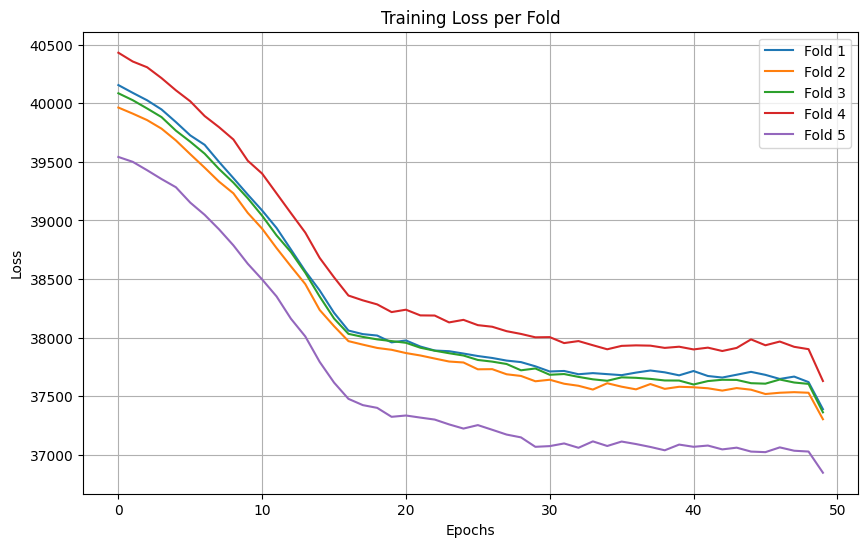

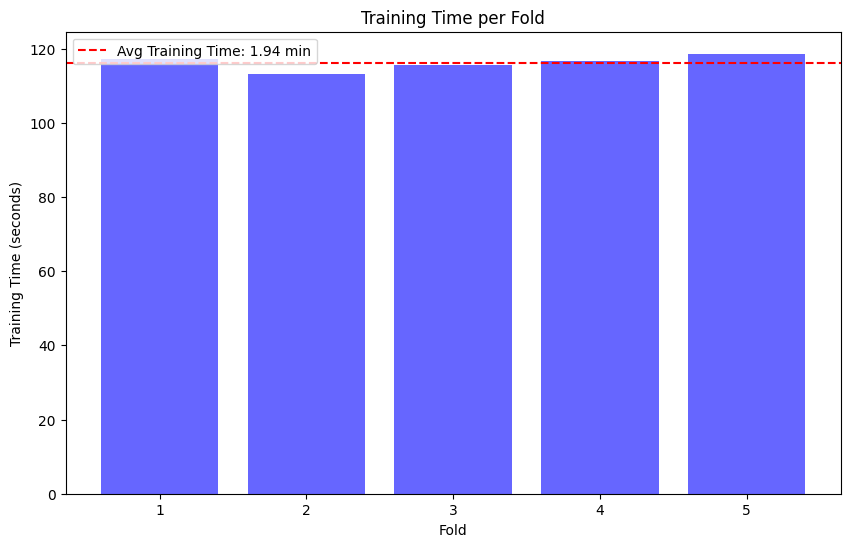

In [17]:
import matplotlib.pyplot as plt

summarize_results(history_regions, durations)
